In [53]:
from IPython import display
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import copy

In [54]:
def Fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])]
         #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        )
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)



# Load data
data = Fashion_mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)  #600*100
num_batches

600

In [56]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [57]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [58]:
#generator = Generator().cuda()
#discriminator = Discriminator().cuda()
discriminator = Discriminator()
generator = Generator()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [59]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [60]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

In [61]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    #real_loss = criterion(real_validity, Variable(torch.ones(batch_size))
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)))
    
    # train with fake images
    #z = Variable(torch.randn(batch_size, 100))
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    #return d_loss.data[0]
    return d_loss.data

In [62]:
num_epochs = 60
n_critic = 5
display_step = 300
N=600

D_loss=[]
G_loss=[]

for epoch in range(num_epochs):
    LossD=0
    LossG=0
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images)
        labels = Variable(labels)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    #generator.eval()
        LossD+=d_loss.item()
        LossG+=g_loss.item()
    D_loss.append(LossD/N)
    G_loss.append(LossG/N)
    print('g_loss: {}, d_loss: {}'.format(LossD/N, LossG/N))
    
    

Starting epoch 0...
g_loss: 0.5552360708887378, d_loss: 2.2871732596556344
Starting epoch 1...
g_loss: 0.33668510779117544, d_loss: 5.004864506324132
Starting epoch 2...
g_loss: 0.33830185525119305, d_loss: 4.007233721613884
Starting epoch 3...
g_loss: 0.3039642550299565, d_loss: 4.1635263808568315
Starting epoch 4...
g_loss: 0.39516733057796954, d_loss: 3.8490209289391837
Starting epoch 5...
g_loss: 0.44246521693964797, d_loss: 3.447467421690623
Starting epoch 6...
g_loss: 0.4041636804242929, d_loss: 3.371816961765289
Starting epoch 7...
g_loss: 0.4986153262356917, d_loss: 3.026349799633026
Starting epoch 8...
g_loss: 0.4927991204708815, d_loss: 2.9362874209880827
Starting epoch 9...
g_loss: 0.5335915494213501, d_loss: 2.8350008898973464
Starting epoch 10...
g_loss: 0.592044220417738, d_loss: 2.5423585311571757
Starting epoch 11...
g_loss: 0.620557949145635, d_loss: 2.410455898245176
Starting epoch 12...
g_loss: 0.6727705915272236, d_loss: 2.2827110662062964
Starting epoch 13...
g_los

Text(0, 0.5, 'Training Loss')

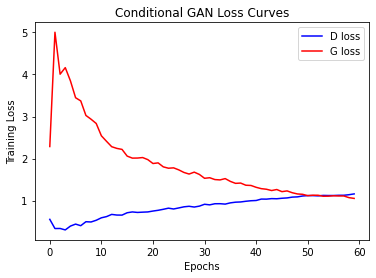

In [64]:
## plot 
plt.title('Conditional GAN Loss Curves')
plt.plot(D_loss,'b')
plt.plot(G_loss,'r')
plt.legend(['D loss','G loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

Starting epoch 0...
g_loss: 3.2572989463806152, d_loss: 0.38505351543426514


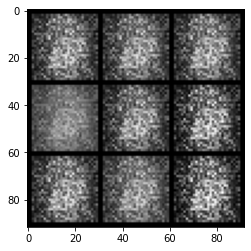

Starting epoch 1...
g_loss: 4.695959568023682, d_loss: 0.3721514344215393


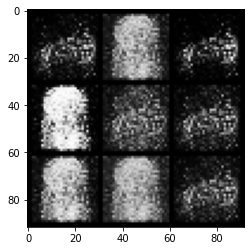

Starting epoch 2...
g_loss: 4.712113380432129, d_loss: 0.26687517762184143


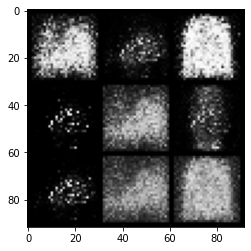

Starting epoch 3...
g_loss: 3.915571928024292, d_loss: 0.41883406043052673


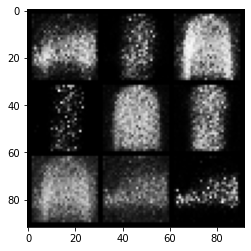

Starting epoch 4...


KeyboardInterrupt: 

In [42]:
    z = Variable(torch.randn(9, 100))
    labels = Variable(torch.LongTensor(np.arange(9)))
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

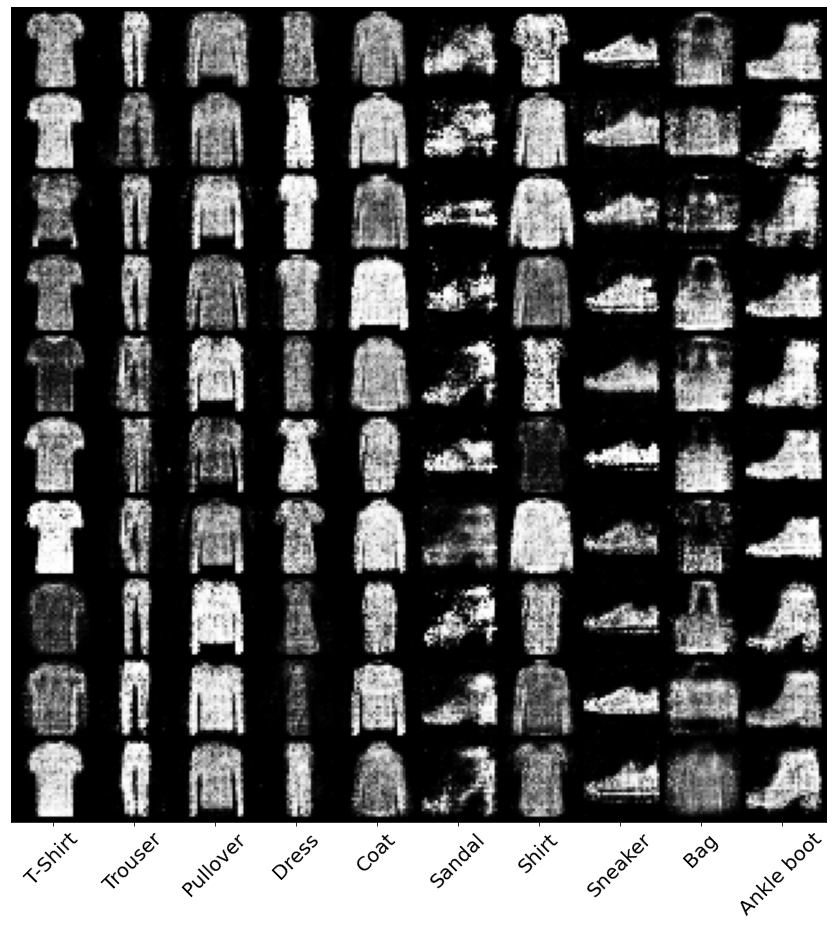

In [65]:
z = Variable(torch.randn(100, 100))
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)]))
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)


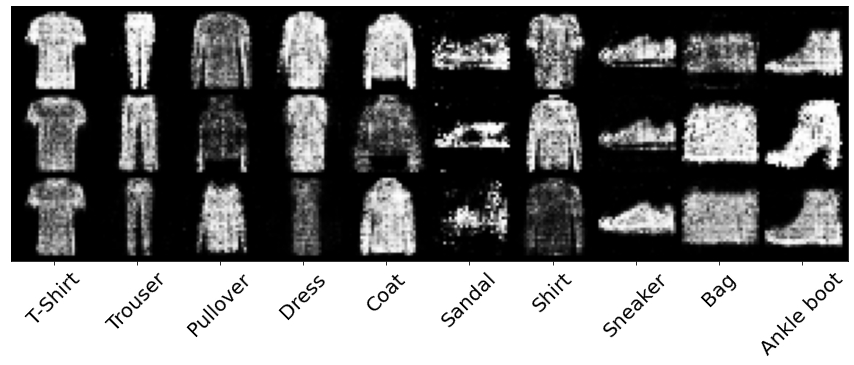

In [69]:
z = Variable(torch.randn(30, 100))
labels = Variable(torch.LongTensor([i for _ in range(3) for i in range(10)]))
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)

